In [1]:
# Standard library imports
import random
import warnings
import sys
import os

# Numerical packages
import numpy as np
import scipy
from scipy.special import i0, iv
from scipy.stats import vonmises

# Data manipulation
import pandas as pd

# Visualization packages
import matplotlib
import matplotlib.lines as mlines
import matplotlib.legend_handler as mlegend_handler
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, FancyArrow
import seaborn as sns

# Statistical modeling packages
import arviz as az
import pymc as pm
import pytensor
import pytensor.tensor as pt

# Parallel computing
import joblib
from joblib import Parallel, delayed

# Other
import numba
from numba import jit, njit
import tqdm as tq
from tqdm.autonotebook import tqdm
from IPython.display import Markdown

/tmp/ipykernel_420740/1944394132.py:40: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [155]:
df = pd.read_parquet("bimodal_locust.parquet")
df.head().style.hide(axis='index')

X,Y,dX,dY,direction,animal_id
0.238824,0.023603,0.238832,0.023572,0.098377,0
0.470628,0.085647,0.231804,0.062045,0.261529,0
0.708734,0.055515,0.238106,-0.030132,-0.125879,0
0.714673,0.295464,0.005939,0.239949,1.546050,0
0.480493,0.242869,-0.234180,-0.052596,-2.920664,0


In [3]:
summary = df.groupby('animal_id').size().reset_index(name='num_steps')
summary.head().style.hide(axis='index')

animal_id,num_steps
0,30
1,22
2,27
3,33
4,139


In [222]:
df['animal_id'].nunique()


52

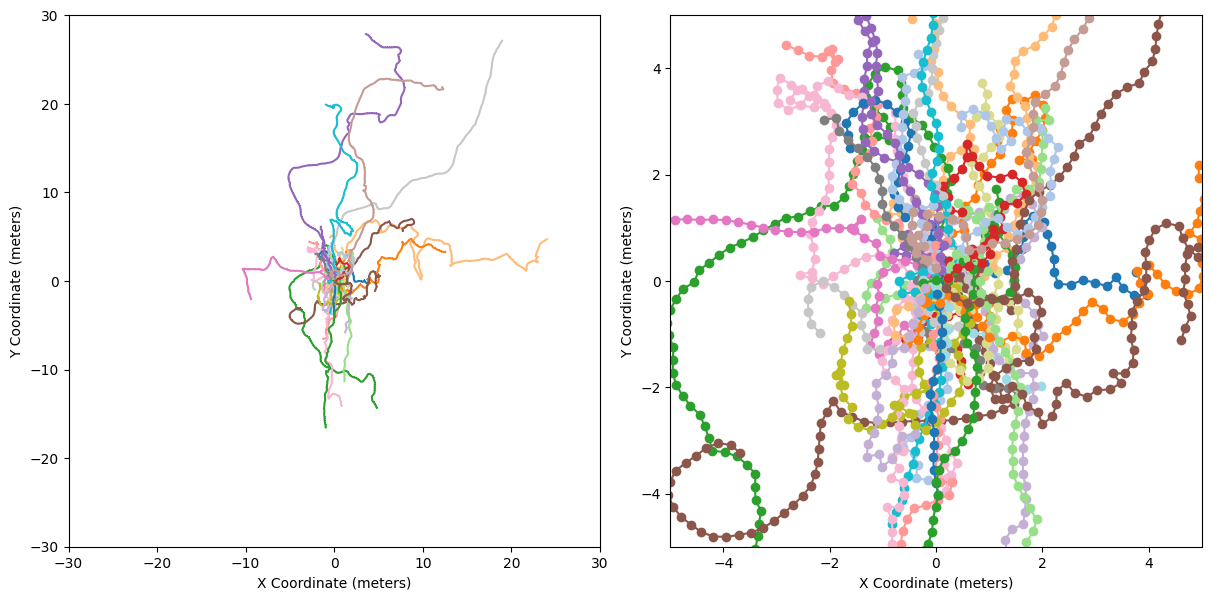

In [4]:
animal_ids = list(df['animal_id'].unique())

# Use a colormap to assign a unique color to each trajectory
colors = plt.cm.tab20.colors  # Use a colormap with 20 distinct colors
# Create a figure with two subplots: one zoomed out and one zoomed in
fig, axs = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)

# Use a colormap to assign a unique color to each trajectory
colors = plt.cm.tab20.colors  # Use a colormap with 20 distinct colors

# Iterate over animal IDs to plot their trajectories
for idx, animal_id in enumerate(animal_ids):
    # Filter the DataFrame for the current locust's trajectory
    individual_df = df[df['animal_id'] == animal_id]

    # Plot zoomed out view (-30 to 30) on the first subplot
    axs[0].plot(individual_df['X'], individual_df['Y'], marker=',', linestyle='-', color=colors[idx % 20])
    axs[0].set_xlim(-30, 30)
    axs[0].set_ylim(-30, 30)
    axs[0].set_xlabel('X Coordinate (meters)')
    axs[0].set_ylabel('Y Coordinate (meters)')
    axs[0].set_aspect(1)

    # Plot zoomed in view (-5 to 5) on the second subplot
    axs[1].plot(individual_df['X'], individual_df['Y'], marker='o', linestyle='-', color=colors[idx % 20])
    axs[1].set_xlim(-5, 5)
    axs[1].set_ylim(-5, 5)
    axs[1].set_xlabel('X Coordinate (meters)')
    axs[1].set_ylabel('Y Coordinate (meters)')
    axs[1].set_aspect(1)

# Show the plots
plt.show()



### Model Definition: Hierarchical Bimodal von Mises Mixture Model

To model the periodic, potentially bimodal directional movement patterns of locusts, we employ a hierarchical bimodal von Mises mixture model. This model captures both population-level (shared) and individual-specific directional patterns, while keeping parameters in appropriate domains via link functions and priors that match the notation used in the main text.

#### Individual-Level Likelihood

For individual $i$, a heading $y \in (-\pi,\pi]$ has likelihood

$$
p(y \mid \Theta_i)
= \omega_i\,\mathcal M\!\bigl(y \mid \mu_{i,1},\kappa_{i,1}\bigr)
+ \bigl(1-\omega_i\bigr)\,\mathcal M\!\bigl(y \mid \mu_{i,2},\kappa_{i,2}\bigr),
$$

where

$$
\mathcal M(y \mid \mu,\kappa)
= \frac{1}{2\pi I_0(\kappa)}\exp\bigl(\kappa\cos(y-\mu)\bigr).
$$

Here:

- $\Theta_i = \{\mu_{i,1},\mu_{i,2},\kappa_{i,1},\kappa_{i,2},\omega_i\}$ are the parameters for individual $i$.
- $\mu_{i,k}$ are the component mean directions, $\mu_{i,k} \in (-\pi,\pi]$.
- $\kappa_{i,k} > 0$ are the component concentrations.
- $\omega_i \in (0,1)$ is the mixture weight for the first component (coded as `weights[i]` in the implementation; the second component has weight $1-\omega_i$).
- $I_0(\kappa)$ is the modified Bessel function of the first kind (order zero).

In code, the latent mixture is represented by `mu[i, k]` and `kappa[i, k]` for components $k \in \{1,2\}$ and `weights[i]$ for $\omega_i$.

### Observations and Dataset Structure

- The full dataset is $Y = \{Y_1,\dots,Y_N\}$, where $N$ is the number of individuals.
- Each $Y_i = \{y_{[i,1]},\dots,y_{[i,M_i]}\}$ is the set of headings for individual $i$, with $M_i$ observations.
- Each $y_{[i,j]}$ is a single heading for individual $i$ at index $j$.

Assuming conditional independence given $\Theta_i$, the full-data likelihood factorizes as

$$
p(Y \mid \Theta)
= \prod_{i=1}^{N} \prod_{j=1}^{M_i} p\!\bigl(y_{[i,j]} \mid \Theta_i\bigr).
$$

This hierarchical setup allows the model to:

1. Capture **individual-specific patterns** through $\Theta_i$ and the data $Y_i$.
2. Share information across individuals via population-level parameters, improving estimates for poorly sampled animals while retaining structure for well-sampled ones.

#### Hierarchical Structure: Population Parameters and Offsets

We separate population-level structure from individual-level deviations using the same notation as in the mixture section of the paper. Let

$$
\boldsymbol{\mu}_0 = (\mu_{0,1},\mu_{0,2}), \qquad
\boldsymbol{\kappa}_0 = (\kappa_{0,1},\kappa_{0,2}), \qquad
\omega_0 \in (0,1)
$$

denote the population-level mixture parameters, and

$$
\boldsymbol{\mu}_i = (\mu_{i,1},\mu_{i,2}), \qquad
\boldsymbol{\kappa}_i = (\kappa_{i,1},\kappa_{i,2}), \qquad
\omega_i
$$

the corresponding parameters for individual $i$.

Individual parameters are defined as population parameters plus unit-specific offsets on appropriate pre-link scales:

$$
\boldsymbol{\mu}_i = \boldsymbol{\mu}_0 + \mathbf{b}_i,
$$

$$
\operatorname{softplus}^{-1}\!\bigl(\boldsymbol{\kappa}_i\bigr)
= \operatorname{softplus}^{-1}\!\bigl(\boldsymbol{\kappa}_0\bigr) + \mathbf{a}_i,
$$

$$
\operatorname{logit}(\omega_i) = \operatorname{logit}(\omega_0) + c_i,
$$

where:

- $\mathbf{b}_i = (b_{[1,i]}, b_{[2,i]})$ are offsets for the component mean directions.
- $\mathbf{a}_i = (a_{[1,i]}, a_{[2,i]})$ are offsets for the component concentrations on the **pre–softplus** scale.
- $c_i$ is a scalar offset for the mixture weight on the **logit** scale.
- $\operatorname{softplus}(x) = \log(1+\exp x)$ and
  $\operatorname{logit}(\omega) = \log\!\bigl(\omega/(1-\omega)\bigr)$.

Componentwise, for $k \in \{1,2\}$,

$$
\mu_{i,k} = \mu_{0,k} + b_{[k,i]},
$$

$$
\operatorname{softplus}^{-1}(\kappa_{i,k})
= \operatorname{softplus}^{-1}(\kappa_{0,k}) + a_{[k,i]},
$$

and

$$
c_i = \operatorname{logit}(\omega_i) - \operatorname{logit}(\omega_0).
$$

In the implementation:

- `mu_pop_unsorted[k]` holds $\mu_{0,k}$ before sorting for identifiability.
- `mu[i, k]` corresponds to $\mu_{i,k}$.
- `kappa_log_pop[k]` corresponds to $\operatorname{softplus}^{-1}(\kappa_{0,k})$.
- `kappa_log[i, k]` corresponds to $\operatorname{softplus}^{-1}(\kappa_{i,k})$.
- `weights_logit_pop` is $\operatorname{logit}(\omega_0)$.
- `weights_logit[i]` is $\operatorname{logit}(\omega_i)$.

Setting all offsets to zero, $\mathbf{b}_i = \mathbf{0}$, $\mathbf{a}_i = \mathbf{0}$, $c_i = 0$, recovers the **population mixture**
$\Theta_0 = \{\boldsymbol{\mu}_0,\boldsymbol{\kappa}_0,\omega_0\}$.

In [5]:
from unwrap.link.pymc import atan2, circular_modulo
from pymc.distributions.transforms import LogExpM1 as Softplus
# Define the data based on df
directions = df['direction'].values
individuals = df['animal_id'].values.astype(np.int32)
num_individuals = df['animal_id'].nunique()

def inverse_softplus(x):
    return pt.log(pt.exp(x) - 1)

def sort(x, sort_idx):
    # Works for shape (2,) or (..., 2)
    return pt.take(x, sort_idx, axis=-1)

with pm.Model() as hierarchical_directional_model_bimodal:

    # --- POPULATION MEANS (unsorted + sorted) ---
    mu_pop_unsorted = pm.VonMises("mu_pop_unsorted", mu=0, kappa=1e-6, shape=(2,))
    # Sort index derived ONCE from the population means
    sort_idx = pt.argsort(mu_pop_unsorted)
    mu_pop = pm.Deterministic("mu_pop", sort(mu_pop_unsorted, sort_idx))

    # --- COMPONENT KAPPA FOR MU (unsorted + sorted) ---
    mu_kappa_unsorted = pm.LogNormal("mu_kappa_unsorted", mu=np.log(30.0), sigma=0.1, shape=(2,))
    mu_kappa = pm.Deterministic("mu_kappa", sort(mu_kappa_unsorted, sort_idx))

    # --- INDIVIDUAL MEANS (unsorted + sorted) ---
    mu_unsorted = pm.VonMises("mu_unsorted", mu=0, kappa=mu_kappa_unsorted, shape=(num_individuals, 2)) + mu_pop_unsorted
    # Sort along the component axis using the SAME sort index
    mu = pm.Deterministic("mu", circular_modulo(sort(mu_unsorted, sort_idx)))

    # --- POPULATION KAPPA (unsorted + sorted) ---
    kappa_log_pop_unsorted = pm.Normal("kappa_log_pop_unsorted", mu=inverse_softplus(2.0), sigma=0.5, shape=(2,))
    kappa_pop_unsorted = pt.softplus(kappa_log_pop_unsorted)
    kappa_pop = pm.Deterministic("kappa_pop", sort(kappa_pop_unsorted, sort_idx))

    # --- INDIVIDUAL KAPPA (unsorted + sorted) ---
    kappa_sigma_unsorted = pm.HalfNormal("kappa_sigma_unsorted", sigma=1.5, shape=(2,))
    kappa_sigma = pm.Deterministic("kappa_sigma", sort(kappa_sigma_unsorted, sort_idx))
    kappa_log_unsorted = (pm.Normal("kappa_log_unsorted", mu=0, sigma=1.0, shape=(num_individuals, 2))
                          * kappa_sigma_unsorted + kappa_log_pop_unsorted)
    kappa_unsorted = pt.softplus(kappa_log_unsorted)
    kappa = pm.Deterministic("kappa", sort(kappa_unsorted, sort_idx))

    # --- WEIGHTS (also sorted so components stay aligned) ---
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=0.5)
    weights_pop_unsorted = pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop]))
    weights_pop = pm.Deterministic("weights_pop", sort(weights_pop_unsorted, sort_idx))
    
    logit_sigma = pm.HalfNormal("logit_sigma", sigma=3.0)
    weights_logit = pm.Normal("weights_logit_unsorted", mu=0, sigma=1.0, shape=(num_individuals,)) * logit_sigma + weights_logit_pop
    weights_unsorted = pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1))
    weights = pm.Deterministic("weights", sort(weights_unsorted, sort_idx))

    # --- Mixture components / likelihood ---
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)


In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    with hierarchical_directional_model_bimodal:
        trace_bimodal = pm.sample(1000, target_accept=0.9, return_inferencedata=True, idata_kwargs={"log_likelihood": True}
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_unsorted, mu_kappa_unsorted, mu_unsorted, kappa_log_pop_unsorted, kappa_sigma_unsorted, kappa_log_unsorted, weights_logit_pop, logit_sigma, weights_logit_unsorted]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 228 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
summary_df = az.summary(trace_bimodal, circ_var_names=["mu_pop", "mu"])
summary_df.loc[
    ~summary_df.index.astype(str).str.contains('_unsorted', na=False) 
    & ((summary_df['r_hat'] > 1.01) | (summary_df['ess_bulk'] < 400))
]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


#### Hierarchical unimodal von Mises model

For comparison to the bimodal mixture, we also fit a hierarchical **unimodal** von Mises model in which each individual has a single preferred direction and concentration.

For individual $i$, a heading $y \in (-\pi,\pi]$ has likelihood
$$
p(y \mid \Theta_i)
= \mathcal M(y \mid \mu_i,\kappa_i),
$$
with
$$
\mathcal M(y \mid \mu,\kappa)
= \frac{1}{2\pi I_0(\kappa)} \exp\bigl(\kappa \cos(y-\mu)\bigr),
$$
where $\Theta_i = {\mu_i,\kappa_i}$, the mean direction $\mu_i \in (-\pi,\pi]$, the concentration $\kappa_i > 0$, and $I_0(\kappa)$ is the modified Bessel function of the first kind of order zero.

Let $Y_i = {y_{[i,1]},\dots,y_{[i,M_i]}}$ denote the headings for individual $i$, and $Y = {Y_1,\dots,Y_N}$ the full dataset from $N$ individuals.
As in the bimodal case, we separate population-level structure from individual-level deviations via a hierarchical parameterization.

This unimodal hierarchical model provides a simpler baseline in which each animal has a single preferred direction $\mu_i$ and concentration $\kappa_i$, regularized toward shared population values $(\mu_0,\kappa_0)$. It is used as a comparison point for the more flexible bimodal mixture model to assess whether the data warrant modeling two distinct directional modes.


In [40]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np
from unwrap.link.pymc import circular_modulo

# --- Data ---
directions = df['direction'].values
individuals = df['animal_id'].values.astype(np.int32)
num_individuals = df['animal_id'].nunique()

def inverse_softplus(x):
    return pt.log(pt.exp(x) - 1)

with pm.Model() as hierarchical_directional_model_unimodal:

    # --- Population mean angle (single component) ---
    mu_pop = pm.VonMises("mu_pop", mu=0.0, kappa=1e-6)

    # --- Mean concentration (kappa for mu) ---
    mu_kappa = pm.LogNormal("mu_kappa", mu=np.log(10.0), sigma=0.1)

    # --- Individual means around population mean (keeps name 'mu') ---
    mu_raw = pm.VonMises("mu_raw", mu=0.0, kappa=mu_kappa, shape=num_individuals)
    mu = pm.Deterministic("mu", circular_modulo(mu_raw + mu_pop))

    # --- Observation concentration hierarchy (per-individual kappas) ---
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(1.5), sigma=0.5)
    kappa_sigma = pm.HalfNormal("kappa_sigma", sigma=1.5)

    kappa_log = pm.Normal("kappa_log", mu=0.0, sigma=1.0, shape=num_individuals) * kappa_sigma + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # --- Likelihood: single Von Mises per individual ---
    pm.VonMises(
        "directions_obs",
        mu=mu[individuals],
        kappa=kappa[individuals],
        observed=directions,
    )


In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    with hierarchical_directional_model_unimodal:
        trace_unimodal = pm.sample(1000, target_accept=0.9, return_inferencedata=True, idata_kwargs={"log_likelihood": True},
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, mu_kappa, mu_raw, kappa_log_pop, kappa_sigma, kappa_log]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 258 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [42]:
summary_df = az.summary(trace_unimodal, circ_var_names=["mu_pop", "mu"])
summary_df.loc[
    ~summary_df.index.astype(str).str.contains('_raw', na=False)
    & ((summary_df['r_hat'] > 1.01) | (summary_df['ess_bulk'] < 400))
]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa_log[10],-0.729,0.537,-1.898,0.012,0.036,0.043,364.0,346.0,1.02
mu_pop,-0.147,0.212,-0.562,0.234,0.018,0.010,204.0,296.0,1.02
mu[10],-2.011,0.652,-2.879,-0.244,0.025,0.056,389.0,274.0,1.01
kappa[10],0.604,0.289,0.001,1.009,0.016,0.011,374.0,308.0,1.02


/home/jake/locust_directional_data/locust/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/jake/locust_directional_data/locust/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


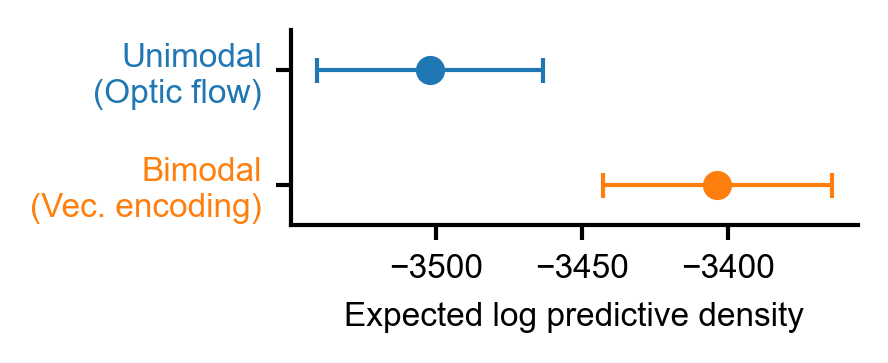

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

plt.rcParams.update({
    "ytick.major.width": 1,
    "xtick.major.width": 1,
    "axes.linewidth": 1,
    "lines.linewidth": 1,
    "font.family": "Arial",
    "font.size": 8,
})

models = {"Bimodal": trace_bimodal, "Unimodal": trace_unimodal}

# Compute ELPD and SE
rows = []
for name, idata in models.items():
    loo = az.loo(idata, pointwise=True, scale="log")
    elpd = float(getattr(loo, "elpd_loo", loo["elpd_loo"]))
    se   = float(getattr(loo, "se", loo["se"]))
    rows.append((name, elpd, se))

# Keep your chosen order (Unimodal then Bimodal)
labels = ["Bimodal\n(Vec. encoding)", "Unimodal\n(Optic flow)"]
colors = ["tab:orange", "tab:blue"]  # Unimodal -> blue, Bimodal -> orange

x    = np.array([r[1] for r in rows], dtype=float)
xerr = np.array([r[2] for r in rows], dtype=float)
y    = np.arange(len(rows))

fig, ax = plt.subplots(figsize=(3.0, 1.25), dpi=300)

# draw per-point so each can have its own color
for yi, xi, sei, col in zip(y, x, xerr, colors):
    ax.errorbar(
        xi, yi, xerr=sei,
        fmt="o",
        color=col, ecolor=col,
        elinewidth=1, capsize=3, capthick=1,
        markersize=6,
        markeredgecolor=col,
        markeredgewidth=1,
    )

ax.set_yticks(y)
ax.set_yticklabels(labels)

# Color tick labels to match
for lab, col in zip(ax.get_yticklabels(), colors):
    lab.set_color(col)

# whitespace like before
ax.margins(y=0.35)

ax.set_xlabel("Expected log predictive density")
ax.set_ylabel("")
ax.set_title("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for sp in ax.spines.values():
    sp.set_linewidth(1)

ax.tick_params(axis="both", which="both",
               bottom=True, top=False,
               left=True, right=False,
               labelbottom=True, labelleft=True,
               width=1)

plt.tight_layout()

# Save with fixed canvas size (no tight bbox cropping)
plt.savefig("../figures/locust_bimodal_unimodal_elpd.png", dpi=300)
plt.savefig("../figures/locust_bimodal_unimodal_elpd.pdf")

plt.show()


### Model Evaluation: Comparing Posterior Predictive Density with Non-Parametric Estimates

The goal of this section is to evaluate the model fit by comparing the **posterior predictive density** obtained from the Bayesian hierarchical model with **non-parametric estimates** of the density at the population level. We employ multiple methods to compare estimated density of locust movement across directions, including:

- **Posterior Predictive Density**: Using the posterior estimates from the hierarchical model to compute the overall directional density.
- **Bootstrapped Histogram Estimates**: Non-parametric bootstrap sampling to approximate the mean density for each directional bin.
- **Von Mises Kernel Density Estimates (KDE)**: Using a Von Mises kernel to estimate the density smoothly over the entire circle.

This comparison helps us visually and quantitatively assess how well the hierarchical model captures the population-level directional tendencies of locusts.


In [44]:
# Extract posterior samples for population-level parameters
posterior = trace_bimodal["posterior"]

# Define the angles as a tensor vector for input
angles = pt.vector('angles')

def compile_logp_fn(mu, kappa, weights):
    """
    Compiles a log probability evaluation function for a mixture of Von Mises distributions.
    
    Parameters:
    ----------
    mu : ndarray
        Mean directions of the Von Mises components (posterior samples).
    kappa : ndarray
        Concentration parameters of the Von Mises components (posterior samples).
    weights : ndarray
        Mixture weights for the components (posterior samples).
    
    Returns:
    -------
    function
        A compiled function to evaluate the log probability of the mixture model for given angles.
    """
    # Create Von Mises components, adding extra dimension for broadcasting
    components = pm.VonMises.dist(mu=mu[:, None], kappa=kappa[:, None])
    
    # Define the mixture model using weights and the Von Mises components
    directions_mixture = pm.Mixture.dist(w=weights[:, None], comp_dists=components)
    
    # Compute the log probability over the vector of angles, broadcasting shapes as needed
    logp = pm.logp(directions_mixture, angles[None, :])
    
    # Compile the log probability function for efficient evaluation
    return pm.compile([angles], logp)

# Compile the function using the posterior samples for the population-level parameters
logp_fn = compile_logp_fn(posterior["mu_pop"].values.reshape(-1, 2),
                          posterior["kappa_pop"].values.reshape(-1, 2),
                          posterior["weights_pop"].values.reshape(-1, 2))

# Define a numpy array of angles from -π to π for evaluation
angle_values = np.linspace(-np.pi, np.pi, 360).astype(np.float64)

# Evaluate the compiled log probability function across all angles
logp_values = logp_fn(angle_values)

# Compute percentiles (2.5%, 50%, 97.5%) of the log probabilities across posterior samples
logp_lower, logp_median, logp_upper = np.percentile(logp_values, [2.5, 50, 97.5], axis=0)

# Convert log probabilities to densities for visualization
density_lower, density_median, density_upper = np.exp(logp_lower), np.exp(logp_median), np.exp(logp_upper)

In [45]:
def hierarchical_bootstrap(
    data,
    labels,
    compute_func,
    n_bootstraps=10000,
    n_jobs=-1,
    random_state=None
):
    """
    Two-stage hierarchical bootstrap:
      (1) Bootstrap labels (clusters) with replacement.
      (2) For each selected label, bootstrap its observations with replacement.
      (3) Aggregate per-label results (mean along axis=0).

    Parameters
    ----------
    data : array-like (shape: (N, ...) )
        Observations (any shape; first axis indexes observations).
    labels : array-like (shape: (N,))
        Cluster/individual labels for each observation.
    compute_func : callable
        Function applied to a *within-label* bootstrap sample (array of observations
        for that label). Should return a scalar or 1D/ND array; results are averaged
        across labels along axis=0 for each bootstrap iteration.
    n_bootstraps : int, optional
        Number of bootstrap iterations (default 4000).
    n_jobs : int, optional
        Number of parallel jobs for iterations (default -1 = all cores).
    random_state : int or np.random.Generator, optional
        Seed or Generator for reproducibility.

    Returns
    -------
    np.ndarray
        Array of shape (n_bootstraps, *result_shape*) with the aggregated result per iteration.
    """
    data = np.asarray(data)
    labels = np.asarray(labels)

    # RNG setup
    rng = np.random.default_rng(random_state)

    # Precompute label index lists for speed
    unique_labels, inverse = np.unique(labels, return_inverse=True)
    label_to_indices = [np.flatnonzero(inverse == i) for i in range(len(unique_labels))]
    n_labels = len(unique_labels)

    def single_bootstrap(seed):
        # per-iteration RNG (independent across workers)
        r = np.random.default_rng(seed)

        # (1) bootstrap labels
        sampled_label_ids = r.integers(0, n_labels, size=n_labels, endpoint=False)

        per_label_results = []

        # (2) within each sampled label, bootstrap observations
        for lid in sampled_label_ids:
            idx = label_to_indices[lid]
            # resample the *indices* within this label
            boot_idx = idx[r.integers(0, len(idx), size=len(idx), endpoint=False)]
            boot_sample = data[boot_idx]
            # (3a) compute per-label statistic
            per_label_results.append(compute_func(boot_sample))

        per_label_results = np.array(per_label_results)
        # (3b) aggregate across labels; duplicates are naturally weighted by multiplicity
        return np.mean(per_label_results, axis=0)

    # Draw independent seeds for each iteration so Parallel is reproducible
    seeds = rng.integers(0, np.iinfo(np.int32).max, size=n_bootstraps, endpoint=False)

    bootstrap_results = Parallel(n_jobs=n_jobs)(
        delayed(single_bootstrap)(int(s)) for s in tqdm(seeds, desc="Hierarchical bootstrapping")
    )

    return np.asarray(bootstrap_results)


def bootstrap_summary_stats(bootstrap_samples, axis=0, lower=2.5, upper=97.5):
    """
    Compute summary statistics (median and confidence intervals) from bootstrap samples.

    Parameters:
    ----------
    bootstrap_samples : array-like
        Bootstrap samples. The shape and interpretation depend on the application.
        For example, in a histogram context, this might be (n_bootstraps x n_bins).
    axis : int, optional
        Axis along which to compute the statistics (default is 0).
    lower : float, optional
        Lower percentile for the confidence interval (default is 2.5).
    upper : float, optional
        Upper percentile for the confidence interval (default is 97.5).

    Returns:
    -------
    dict
        Contains:
        - 'median': Median values along the specified axis.
        - 'lower_bounds': Lower bounds of the confidence interval.
        - 'upper_bounds': Upper bounds of the confidence interval.
        - 'errors': Tuple of errors ([median - lower_bounds], [upper_bounds - median]).
    """
    if lower >= upper:
        raise ValueError("`lower` must be less than `upper`.")

    # Compute required percentiles
    percentiles_values = np.percentile(bootstrap_samples, [lower, 50, upper], axis=axis)
    lower_bounds, median, upper_bounds = percentiles_values

    # Calculate errors
    errors = np.array([median - lower_bounds, upper_bounds - median])
    
    return {
        'median': median,
        'lower_bounds': lower_bounds,
        'upper_bounds': upper_bounds,
        'errors': errors
    }
    
@jit(nopython=True)
def histogram(data_sample, bins):
    """
    Compute histogram using Numba with normalization.

    Parameters:
    ----------
    data_sample : array-like
        Data sample to compute the histogram for.
    bins : array-like
        Bin edges for the histogram.

    Returns:
    -------
    np.ndarray
        Histogram counts normalized to density.
    """
    n_bins = len(bins) - 1
    hist = np.zeros(n_bins)

    for value in data_sample:
        for i in range(n_bins):
            if bins[i] <= value < bins[i + 1]:
                hist[i] += 1
                break
        # Include the rightmost edge case
        if value == bins[-1]:
            hist[-1] += 1

    # Normalize to density
    bin_widths = np.diff(bins)
    hist = hist / (np.sum(hist) * bin_widths)

    return hist

def bootstrap_histogram(data, labels, n_bins=16, n_bootstraps=4000):
    """
    Bootstrap histograms for directional data with hierarchical sampling.

    Parameters:
    ----------
    data : array-like
        Array of directional data (angles in radians).
    labels : array-like
        Array of individual labels corresponding to the data.
    n_bins : int, optional
        Number of bins for the histogram (default is 16).
    n_bootstraps : int, optional
        Number of bootstrap iterations (default is 4000).

    Returns:
    -------
    dict
        Contains:
        - 'bootstrap_histograms': Bootstrap distribution of mean histograms (n_bootstraps x n_bins).
        - 'bin_centers': Array of bin centers.
    """
    # Ensure data is in the range [-π, π]
    data = (data + np.pi) % (2 * np.pi) - np.pi

    # Define bins and bin centers
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # # Define histogram computation function
    # def compute_histogram(data_sample):
    #     hist, _ = np.histogram(data_sample, bins=bins, density=True)
    #     return hist
    # Define histogram computation function
    def compute_histogram(data_sample):
        return histogram(data_sample, bins=bins)

    
    # Perform hierarchical bootstrapping
    bootstrap_histograms = hierarchical_bootstrap(data, labels, compute_histogram, n_bootstraps)

    return {
        'bootstrap_histograms': bootstrap_histograms,
        'bin_centers': bin_centers
    }

# Example directional data and labels
directions = df['direction'].values
labels = df['animal_id'].values

# Compute bootstrap histograms
bootstrap_results = bootstrap_histogram(directions, labels, n_bins=16, n_bootstraps=1000)

# Compute summary statistics
summary_stats = bootstrap_summary_stats(bootstrap_results['bootstrap_histograms'])

# Access results
hist_bin_centers = bootstrap_results['bin_centers']
hist_median = summary_stats['median']
hist_lower_bounds = summary_stats['lower_bounds']
hist_upper_bounds = summary_stats['upper_bounds']
hist_errors = summary_stats['errors']


Hierarchical bootstrapping:   0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
def von_mises_kde(data, points, kappa):
    """
    Compute the Von Mises kernel density estimate (KDE) at given points.

    Parameters:
    ----------
    data : array-like
        Input data (angles in radians). Each value should be within the range [-π, π].
    points : array-like
        Points at which to evaluate the KDE (angles in radians).
    kappa : float
        Concentration parameter of the Von Mises distribution, controlling the "peakiness".

    Returns:
    -------
    np.ndarray
        KDE values evaluated at the input points. Each value represents the estimated density
        at the corresponding point.
    
    Notes:
    -----
    - This function uses vectorized operations for efficient computation.
    - The kernel density is computed by averaging the Von Mises kernel values across the data,
      where the kernel is defined as exp(kappa * cos(point - data)).
    """
    c = 1 / (2 * np.pi * i0(kappa))
    cos_diffs = np.cos(points[:, None] - data)
    exp_vals = np.exp(kappa * cos_diffs)
    return c * exp_vals.mean(axis=1)

def bootstrap_von_mises_kde(data, labels, kappa, n_bootstraps=1000, n_points=360):
    """
    Computes bootstrapped Von Mises KDE estimates using hierarchical bootstrapping.

    Parameters:
    ----------
    data : array-like
        Input data (angles in radians).
    labels : array-like
        Individual labels corresponding to the data.
    kappa : float
        Concentration parameter of the Von Mises distribution.
    n_bootstraps : int, optional
        Number of bootstrap iterations (default is 4000).
    n_points : int, optional
        Number of points to evaluate the KDE (default is 360).

    Returns:
    -------
    dict
        Contains:
        - 'bootstrap_kdes': Bootstrap distribution of KDE results (n_bootstraps x n_points).
        - 'angles': Array of angles where the KDE is evaluated.
    """
    # Ensure data is in the range [-π, π]
    data = (data + np.pi) % (2 * np.pi) - np.pi

    # Define points for KDE evaluation
    angles = np.linspace(-np.pi, np.pi, n_points)

    # Define KDE computation function for hierarchical bootstrapping
    def compute_kde(bootstrapped_sample):
        return von_mises_kde(bootstrapped_sample, angles, kappa)

    # Perform hierarchical bootstrapping
    bootstrap_kdes = hierarchical_bootstrap(data, labels, compute_kde, n_bootstraps)

    return {
        'bootstrap_kdes': bootstrap_kdes,
        'angles': angles
    }

# Reuse the `bootstrap_summary_stats` function from before for KDE summary statistics
# Example usage:
directions = df['direction'].values
labels = df['animal_id'].values

n_points = 360
kappa = 30.0
bootstrap_kde_results = bootstrap_von_mises_kde(directions, labels, kappa=kappa, n_points=n_points)

summary_stats = bootstrap_summary_stats(bootstrap_kde_results['bootstrap_kdes'])

# Access results
kde_angles = bootstrap_kde_results['angles']
kde_median = summary_stats['median']
kde_lower_bounds = summary_stats['lower_bounds']
kde_upper_bounds = summary_stats['upper_bounds']


Hierarchical bootstrapping:   0%|          | 0/5000 [00:00<?, ?it/s]

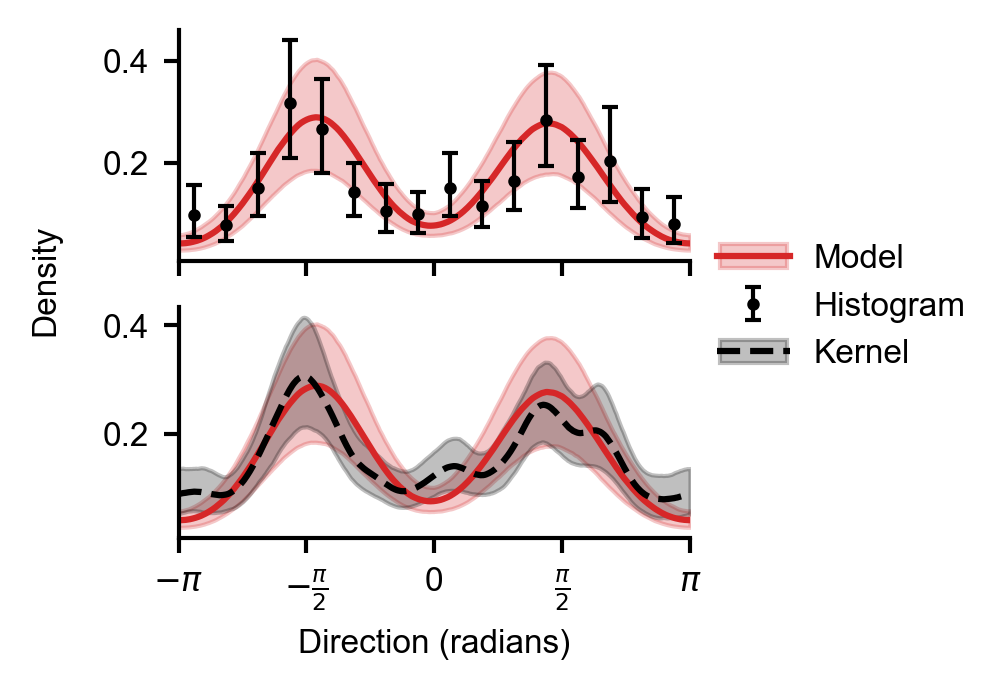

In [108]:
# Custom legend handler
def customer_handler(color, linestyle=None):
    class HandlerLineInPatch(mlegend_handler.HandlerBase):
        def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans, ):
            # Create a patch as the background
            patch = mpatches.Rectangle(xy=(-xdescent, -ydescent), width=width, height=height, color=color, alpha=0.25, transform=trans)
            
            # Create a line across the center of the patch
            line = mlines.Line2D([-0.05*width, 1.05*width], [0.5*height, 0.5*height], color=color, transform=trans + legend.get_transform(), linestyle=linestyle)
            
            return [patch, line]
    return HandlerLineInPatch()

# Assume bin_centers, median, errors, angles, density_median, density_lower, density_upper are already defined
# Plot adjustments as per Sercan's request
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1.1*2, 1.1 * 2), sharex=True, dpi=300)
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 8})


angles = np.linspace(-np.pi, np.pi, n_points)

# Posterior Density line and fill
for ax in [ax1, ax2]:
    line_plot, = ax.plot(angles, density_median, 'tab:red', label='Posterior Density')
    fill_plot = ax.fill_between(angles, density_lower, density_upper, color='tab:red', alpha=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


fill_plot_kde = ax2.fill_between(kde_angles, kde_lower_bounds, kde_upper_bounds, color='black', alpha=0.25)
line_plot_kde, = ax2.plot(kde_angles, kde_median, label='Median KDE', color="black", linestyle="--")

# # Error bars for the median
errorbar_plot = ax1.errorbar(hist_bin_centers, hist_median, yerr=hist_errors, fmt='o', ecolor='black', 
             markeredgecolor='black', markerfacecolor='black', linewidth=1, capsize=2, 
             markersize=2, label="Bootstrap Density\n(Median ± 95% C.I.)")

ax2.set_xlabel('Direction (radians)')
ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\frac{\pi}{2}$", r"0", r"$\frac{\pi}{2}$", r"$\pi$"])

plt.xlim(-np.pi, np.pi)
# Creating a shared y-label
fig.text(-0.1, 0.5, 'Density', va='center', rotation='vertical')  # Adjust these coordinates as needed


# Creating the legend with both individual and combined entries
plt.legend([line_plot, errorbar_plot, line_plot_kde, ], 
           ["Model", "Histogram", "Kernel"],
           handler_map={line_plot_kde: customer_handler("black", "--"), line_plot: customer_handler("tab:red")},
           bbox_to_anchor=(1, 1), frameon=False, loc="center left")

# plt.savefig("./locust_directional_validation.svg", bbox_inches="tight")
# plt.savefig("./locust_directional_validation.pdf", bbox_inches="tight")
# plt.savefig("./locust_directional_validation.png", bbox_inches="tight", dpi=300)

plt.show()


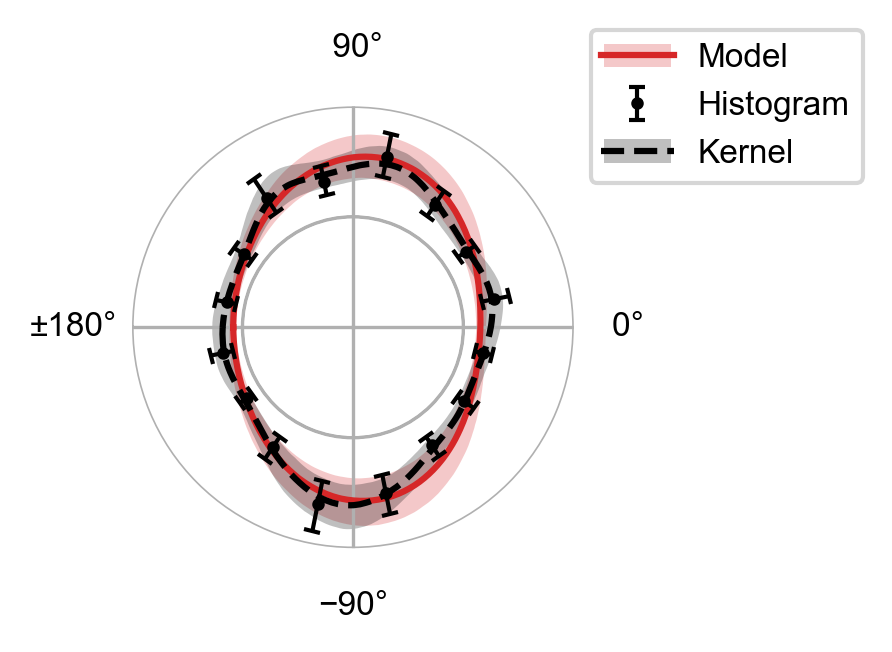

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.legend_handler as mlegend_handler
from matplotlib.patches import Circle

# -------------------------------------------------------------------
# Custom legend handler: filled patch + center line (your style)
# -------------------------------------------------------------------
def customer_handler(color, linestyle=None, alpha=0.25, linewidth=1.5):
    class HandlerLineInPatch(mlegend_handler.HandlerBase):
        def create_artists(
            self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
        ):
            patch = mpatches.Rectangle(
                xy=(-xdescent, -ydescent),
                width=width,
                height=height,
                facecolor=color,
                edgecolor="none",
                alpha=alpha,
                transform=trans,
            )

            line = mlines.Line2D(
                [-0.05 * width, 1.05 * width],
                [0.5 * height, 0.5 * height],
                color=color,
                linestyle=linestyle if linestyle is not None else "-",
                linewidth=linewidth,
                transform=trans,
            )

            return [patch, line]

    return HandlerLineInPatch()

# -------------------------------------------------------------------
# ASSUMES THESE ALREADY EXIST IN YOUR WORKSPACE:
#   angles
#   density_median, density_lower, density_upper
#   kde_angles, kde_median, kde_lower_bounds, kde_upper_bounds
#   hist_bin_centers, hist_median, hist_lower_bounds, hist_upper_bounds
#   posterior (optional; if you need mu_mean/weights_mean elsewhere)
# -------------------------------------------------------------------

# -------------------------------------------------------------------
# Styling (set before plotting)
# -------------------------------------------------------------------
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({"font.size": 8})

edge_radius = 0.5

# If you need these later, keep them; otherwise you can delete
# mu_mean = posterior["mu_pop"].mean(dim=["chain", "draw"]).values
# weights_mean = posterior["weights_pop"].mean(dim=["chain", "draw"]).values

# -------------------------------------------------------------------
# Plot
# -------------------------------------------------------------------
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(3, 3), dpi=300)

# Model posterior density (line + fill)
line_plot, = ax.plot(
    angles,
    edge_radius + density_median,
    color="tab:red",
    linewidth=1.5,
    label="Model",
)
ax.fill_between(
    angles,
    edge_radius + density_lower,
    edge_radius + density_upper,
    color="tab:red",
    alpha=0.25,
    edgecolor="none",
)

# KDE (line + fill)
line_plot_kde, = ax.plot(
    kde_angles,
    edge_radius + kde_median,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Kernel",
)
ax.fill_between(
    kde_angles,
    edge_radius + kde_lower_bounds,
    edge_radius + kde_upper_bounds,
    color="black",
    alpha=0.25,
    edgecolor="none",
)

# Histogram bootstrap errorbars
errorbar_plot = ax.errorbar(
    hist_bin_centers,
    edge_radius + hist_median,
    yerr=[
        (hist_median + edge_radius) - (hist_lower_bounds + edge_radius),
        (hist_upper_bounds + edge_radius) - (hist_median + edge_radius),
    ],
    fmt="o",
    ecolor="black",
    markeredgecolor="black",
    markerfacecolor="black",
    linewidth=1,
    capsize=2,
    markersize=2,
    label="Histogram",
)

# Outer circle outline (visual reference)
outer_circle = Circle(
    (0, 0),
    edge_radius,
    transform=ax.transData._b,
    color="black",
    fill=False,
    linewidth=0.5,
)
ax.add_artist(outer_circle)

# Clean polar frame
ax.spines["polar"].set_visible(False)

# Axis ticks/labels
ax.set_ylim(0, edge_radius + np.max(density_upper) * 1.2)
ax.set_xlim(-np.pi, np.pi)
ax.set_xticks([-np.pi / 2, 0, np.pi / 2, np.pi])
ax.set_xticks([-np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels(["−90°", "0° ", " 90°", "±180°"])
ax.set_yticks([edge_radius, edge_radius+0.5])
ax.set_yticklabels(["", ""])

# -------------------------------------------------------------------
# Legend with your custom patch+line styling for Model + Kernel
# -------------------------------------------------------------------
ax.legend(
    [line_plot, errorbar_plot, line_plot_kde],
    ["Model", "Histogram", "Kernel"],
    handler_map={
        line_plot: customer_handler("tab:red", linestyle="-", alpha=0.25, linewidth=1.5),
        line_plot_kde: customer_handler("black", linestyle="--", alpha=0.25, linewidth=1.5),
    },
    bbox_to_anchor=(1, 1),
    loc="center left",
    frameon=True,
)

plt.tight_layout()
plt.savefig("../figures/population_directional_validation.pdf", bbox_inches="tight")
plt.show()


### Individual-Level Directional Predictive Check with Observed Data, Mode Weights, and Residuals

After assessing the population-level parameters, we now examine individual-level estimates within this hierarchical model. This plot compares the posterior predictive distribution (PDF) with observed data directions for each individual, with **arrows** indicating the mean directions of the model’s two modes, scaled by their respective **mean resultant vector lengths** and **mixture weights**. Additionally, the residuals are plotted to visually assess the agreement between the model and the observed data.

This visualization is intended to reveal how well the model aligns with observed patterns at both individual and population levels, showing both the primary predicted directions, the relative weighting and concentration of each mode, and the degree of model agreement through residuals.


Model PPC (posterior band):   0%|          | 0/52 [00:00<?, ?it/s]

Bootstrap KDEs:   0%|          | 0/52 [00:00<?, ?it/s]

Plotting panels:   0%|          | 0/52 [00:00<?, ?it/s]

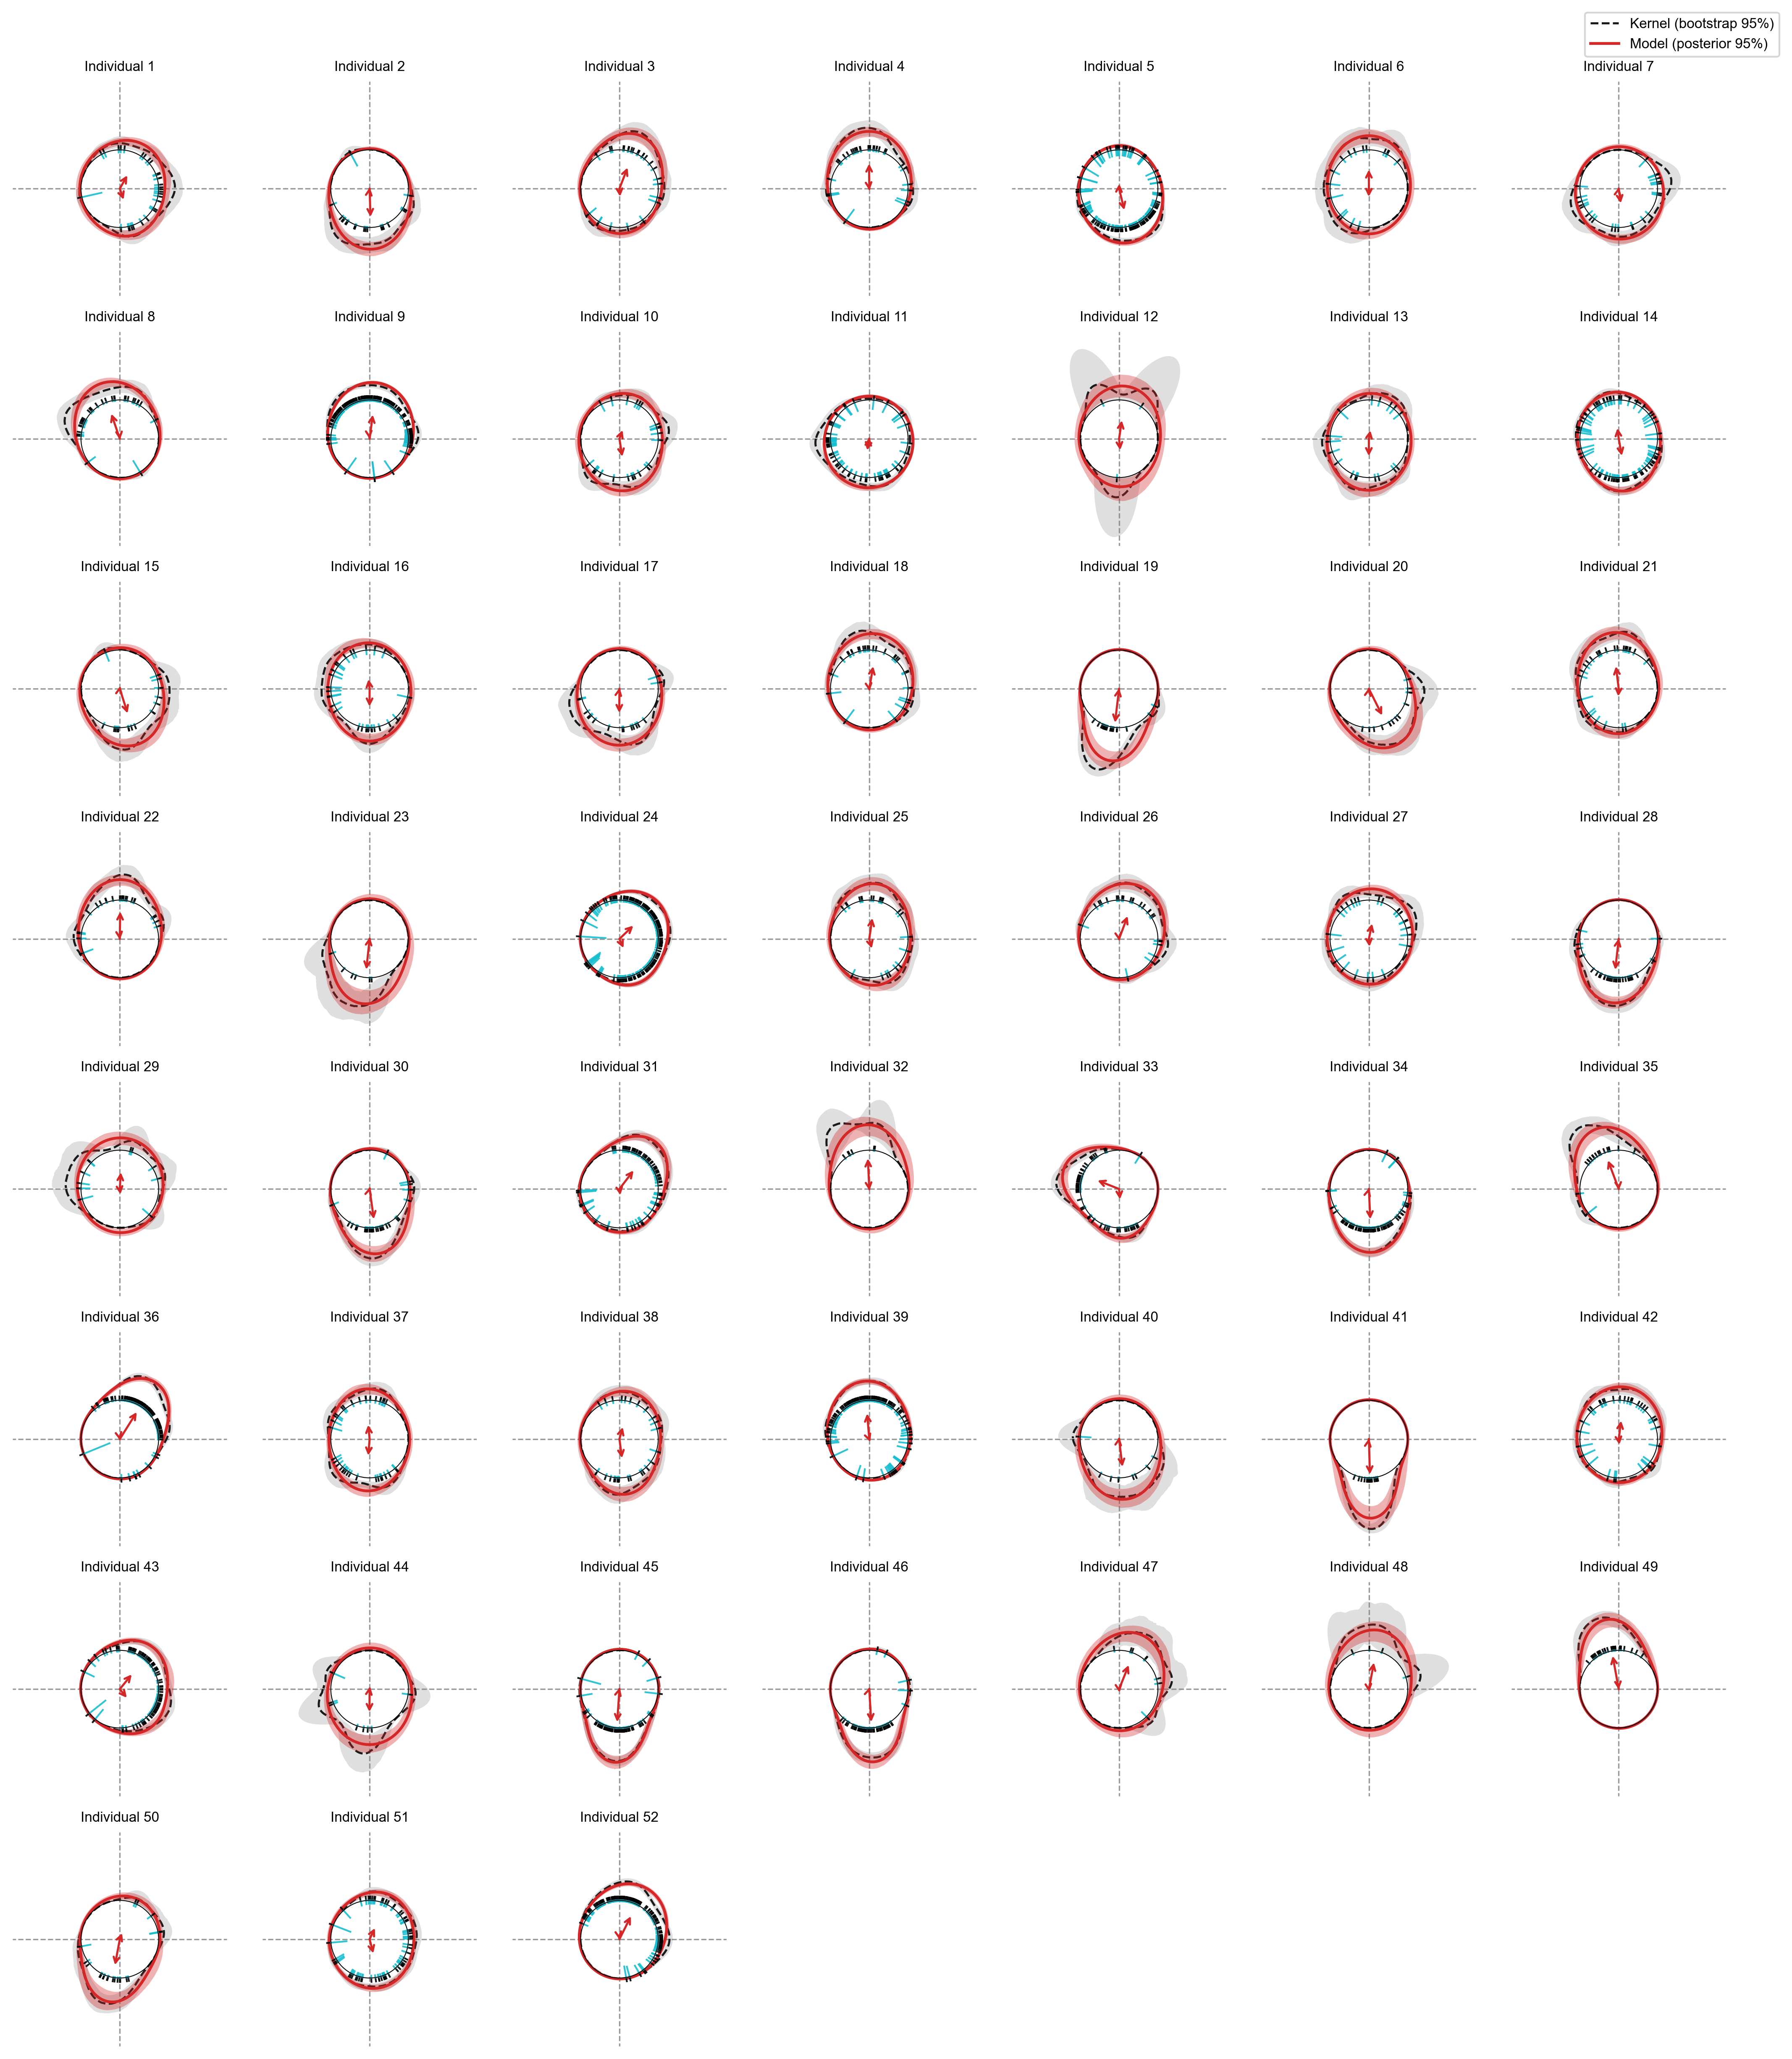

Saved figure to: ../figures/locust_directional_individual_ppc.pdf


In [240]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.stats import vonmises
from scipy.special import iv, i0
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# ============================================================
# Individual-level PPC for 2-component von Mises mixture
#   - Model: posterior mean density + pointwise 95% credible band (red)
#   - Data: bootstrap von Mises KDE + 95% bootstrap band (gray)
#   - Observations: outward ticks (black)
#   - Optional lack-of-fit: inward "residual" ticks (cyan), using inverse mean predictive density
#   - Parallel bootstrap per individual + tqdm progress
#
# ASSUMES THESE EXIST IN YOUR WORKSPACE:
#   posterior  : xarray Dataset with vars ["mu","kappa","weights"]
#               dims (chain, draw, num_individuals, 2)
#   directions : array of observed angles (radians)
#   individuals: array of individual indices (0..num_individuals-1) matching directions
# ============================================================

# ----------------------------
# Settings
# ----------------------------
DPI = 300
N_ANGLES = 360
angles = np.linspace(-np.pi, np.pi, N_ANGLES, endpoint=False)  # evaluation grid

EDGE_RADIUS = 1.0

# KDE settings (data bootstrap)
KAPPA_KDE = 15.0     # fixed kernel concentration (like your population PPC)
N_BOOT_KDE = 1000     # bootstrap reps per individual (increase if you want)
BASE_SEED = 123

# Parallel
N_JOBS = max(1, (os.cpu_count() or 2) - 1)

# Colors
model_band_color = "tab:red"
model_line_color = "tab:red"
kde_band_color = "0.5"   # gray fill
kde_line_color = "0.1"   # dark gray / near black
data_tick_color = "black"
residual_color = "tab:cyan"
ref_line_color = "gray"

# Save
OUT_DIR = "../figures"
OUT_NAME = "locust_directional_individual_ppc.pdf"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PATH = os.path.join(OUT_DIR, OUT_NAME)


# ----------------------------
# Helpers
# ----------------------------
def wrap_pm_pi(x):
    x = np.asarray(x, float)
    return (x + np.pi) % (2 * np.pi) - np.pi

def von_mises_kde(data, points, kappa):
    """
    Von Mises KDE with fixed kappa.
    data: (n,)
    points: (A,)
    returns: (A,)
    """
    data = wrap_pm_pi(data)
    c = 1.0 / (2.0 * np.pi * i0(kappa))
    # points[:, None] - data[None, :] => (A, n)
    cos_diffs = np.cos(points[:, None] - data[None, :])
    return c * np.exp(kappa * cos_diffs).mean(axis=1)

def bootstrap_kde_summary(data, points, kappa, n_boot=1000, seed=0):
    """
    Non-hierarchical bootstrap within an individual.
    Returns median, 2.5%, 97.5% bands for KDE(points).
    """
    data = wrap_pm_pi(np.asarray(data, float))
    n = data.size
    if n == 0:
        A = points.size
        return (np.full(A, np.nan), np.full(A, np.nan), np.full(A, np.nan))

    rng = np.random.default_rng(seed)
    boot = np.empty((n_boot, points.size), dtype=np.float32)

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boot[b] = von_mises_kde(data[idx], points, kappa).astype(np.float32)

    med = np.quantile(boot, 0.5, axis=0)
    lo  = np.quantile(boot, 0.025, axis=0)
    hi  = np.quantile(boot, 0.975, axis=0)
    return med.astype(float), lo.astype(float), hi.astype(float)

def _kde_worker(idx, data_1d, points, kappa, n_boot, base_seed):
    med, lo, hi = bootstrap_kde_summary(
        data_1d, points, kappa,
        n_boot=n_boot,
        seed=base_seed + 10_000 + idx
    )
    return idx, med, lo, hi


# ============================================================
# Extract posterior samples as NumPy arrays
# ============================================================
mu_all = posterior["mu"].values           # (chain, draw, num_individuals, 2)
kappa_all = posterior["kappa"].values     # (chain, draw, num_individuals, 2)
weights_all = posterior["weights"].values # (chain, draw, num_individuals, 2)

n_chain, n_draw, num_individuals, n_components = mu_all.shape
assert n_components == 2, "This code assumes 2 mixture components."

n_samples = n_chain * n_draw
mu_flat = mu_all.reshape(n_samples, num_individuals, 2)
kappa_flat = kappa_all.reshape(n_samples, num_individuals, 2)
weights_flat = weights_all.reshape(n_samples, num_individuals, 2)

# Posterior means for arrows / mean density
mu_mean = wrap_pm_pi(mu_flat.mean(axis=0))              # (num_individuals, 2)
kappa_mean = np.asarray(kappa_flat.mean(axis=0), float) # (num_individuals, 2)
weights_mean = np.asarray(weights_flat.mean(axis=0), float)
# guard numeric drift
weights_mean = weights_mean / weights_mean.sum(axis=1, keepdims=True)


# ============================================================
# Pre-split data by individual (so processes only get their own data)
# ============================================================
directions = wrap_pm_pi(np.asarray(directions, float))
individuals = np.asarray(individuals, int)

per_ind_data = []
for idx in range(num_individuals):
    per_ind_data.append(directions[individuals == idx])


# ============================================================
# (A) Model: pointwise 95% credible band + mean PDF per individual
# ============================================================
A = angles.size
pdf_lower = np.zeros((num_individuals, A), dtype=float)
pdf_upper = np.zeros((num_individuals, A), dtype=float)
pdf_mean_vals = np.zeros((num_individuals, A), dtype=float)

max_pdf_global = 0.0

theta = angles[None, :].astype(float)  # (1, A)

for idx in tqdm(range(num_individuals), desc="Model PPC (posterior band)", leave=False):
    mu_draws = mu_flat[:, idx, :]        # (S, 2)
    kappa_draws = kappa_flat[:, idx, :]  # (S, 2)
    weight_draws = weights_flat[:, idx, :]  # (S, 2)

    # (S,1)
    mu0 = wrap_pm_pi(mu_draws[:, 0])[:, None]
    mu1 = wrap_pm_pi(mu_draws[:, 1])[:, None]
    k0 = np.asarray(kappa_draws[:, 0], float)[:, None]
    k1 = np.asarray(kappa_draws[:, 1], float)[:, None]

    w0 = np.clip(np.asarray(weight_draws[:, 0], float)[:, None], 1e-12, 1.0)
    w1 = np.clip(np.asarray(weight_draws[:, 1], float)[:, None], 1e-12, 1.0)
    ws = w0 + w1
    w0 = w0 / ws
    w1 = w1 / ws

    # Vectorized mixture PDF over (S, A)
    log_c1 = np.log(w0) + vonmises.logpdf(theta, k0, loc=mu0)  # (S, A)
    log_c2 = np.log(w1) + vonmises.logpdf(theta, k1, loc=mu1)  # (S, A)
    log_pdf_samples = np.logaddexp(log_c1, log_c2).astype(np.float32)
    pdf_samples = np.exp(log_pdf_samples).astype(np.float32)   # (S, A)

    # Pointwise 95% interval across draws
    pdf_lower[idx] = np.quantile(pdf_samples, 0.025, axis=0)
    pdf_upper[idx] = np.quantile(pdf_samples, 0.975, axis=0)

    # Mean posterior PDF using mean parameters
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = np.clip(weights_mean[idx], 1e-12, 1.0)
    weights_ind = weights_ind / weights_ind.sum()

    log_c1_mean = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_c2_mean = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    pdf_mean = np.exp(np.logaddexp(log_c1_mean, log_c2_mean))

    pdf_mean_vals[idx] = pdf_mean
    max_pdf_global = max(max_pdf_global, float(np.nanmax(pdf_upper[idx])))


# ============================================================
# (B) Data: bootstrap KDE per individual (parallel)
# ============================================================
kde_med = np.full((num_individuals, A), np.nan, dtype=float)
kde_lo  = np.full((num_individuals, A), np.nan, dtype=float)
kde_hi  = np.full((num_individuals, A), np.nan, dtype=float)

# Only schedule individuals with data
todo = [idx for idx in range(num_individuals) if per_ind_data[idx].size > 0]

if len(todo) > 0:
    with ProcessPoolExecutor(max_workers=min(N_JOBS, len(todo))) as ex:
        futs = [
            ex.submit(_kde_worker, idx, per_ind_data[idx], angles, KAPPA_KDE, N_BOOT_KDE, BASE_SEED)
            for idx in todo
        ]
        for f in tqdm(as_completed(futs), total=len(futs), desc="Bootstrap KDEs", leave=False):
            idx, med, lo, hi = f.result()
            kde_med[idx] = med
            kde_lo[idx]  = lo
            kde_hi[idx]  = hi

    max_pdf_global = max(max_pdf_global, float(np.nanmax(kde_hi)))


# ============================================================
# Plot: one polar plot per individual
# ============================================================
ncols = 7
nrows = int(np.ceil(num_individuals / ncols))

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": "polar"},
    figsize=(2.0 * ncols, 2.0 * nrows),
    dpi=DPI,
)
axs = np.array(axs).reshape(-1)

rmax = EDGE_RADIUS + max_pdf_global * 1.15

for idx in tqdm(range(num_individuals), desc="Plotting panels", leave=False):
    ax = axs[idx]

    # Cardinal reference lines
    for a in (0, np.pi, np.pi/2, -np.pi/2):
        ax.plot([a, a], [0, rmax], color=ref_line_color, linestyle="--", linewidth=0.8, alpha=0.8)

    # Observed data for this individual
    individual_data = per_ind_data[idx]

    # ----- KDE bootstrap band (gray) + median (dashed) -----
    if np.isfinite(kde_med[idx]).any():
        ax.fill_between(
            angles,
            EDGE_RADIUS + kde_lo[idx],
            EDGE_RADIUS + kde_hi[idx],
            color=kde_band_color,
            alpha=0.25,
            linewidth=0,
            zorder=1,
        )
        ax.plot(
            angles,
            EDGE_RADIUS + kde_med[idx],
            color=kde_line_color,
            linestyle="--",
            linewidth=1.2,
            label="Kernel (bootstrap 95%)" if idx == 0 else None,
            zorder=2,
        )

    # ----- Model posterior 95% band (red) -----
    lower = pdf_lower[idx]
    upper = pdf_upper[idx]
    mean_pdf = pdf_mean_vals[idx]

    ax.fill_between(
        angles,
        EDGE_RADIUS + lower,
        EDGE_RADIUS + upper,
        color=model_band_color,
        alpha=0.35,
        linewidth=0,
        zorder=3,
    )

    # ----- Model mean posterior PDF (red line) -----
    ax.plot(
        angles,
        EDGE_RADIUS + mean_pdf,
        color=model_line_color,
        linewidth=1.6,
        label="Model (posterior 95%)" if idx == 0 else None,
        zorder=4,
    )

    # ----- observed data as short outward ticks -----
    line_length = 0.10
    for ang in individual_data:
        ax.plot([ang, ang],
                [EDGE_RADIUS, EDGE_RADIUS + line_length],
                color=data_tick_color, alpha=0.9, linewidth=1.0, zorder=5)

    # ----- residual ticks (inward): inverse mean predictive density -----
    if individual_data.size > 0:
        mu_ind = mu_mean[idx]
        kappa_ind = kappa_mean[idx]
        weights_ind = np.clip(weights_mean[idx], 1e-12, 1.0)
        weights_ind = weights_ind / weights_ind.sum()

        log_c1_mean = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
        log_c2_mean = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
        log_pdf_mean_grid = np.logaddexp(log_c1_mean, log_c2_mean)

        inv_pdf_grid = np.exp(-log_pdf_mean_grid)
        norm = np.trapz(inv_pdf_grid, angles)

        for ang in individual_data:
            log_pdf_c1 = np.log(weights_ind[0]) + vonmises.logpdf(ang, kappa_ind[0], loc=mu_ind[0])
            log_pdf_c2 = np.log(weights_ind[1]) + vonmises.logpdf(ang, kappa_ind[1], loc=mu_ind[1])
            log_pdf_val = np.logaddexp(log_pdf_c1, log_pdf_c2)

            inv_val = np.exp(-log_pdf_val)
            residual = -(inv_val / (norm + 1e-12))  # inward
            ax.plot([ang, ang],
                    [EDGE_RADIUS, EDGE_RADIUS + residual],
                    color=residual_color, alpha=0.9, linewidth=1.0, zorder=6)

    # ----- mixture component mean vectors as arrows (red) -----
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = np.clip(weights_mean[idx], 1e-12, 1.0)
    weights_ind = weights_ind / weights_ind.sum()

    R1 = iv(1, kappa_ind[0]) / iv(0, kappa_ind[0])
    R2 = iv(1, kappa_ind[1]) / iv(0, kappa_ind[1])
    arrow_length_1 = EDGE_RADIUS * float(R1) * float(weights_ind[0])
    arrow_length_2 = EDGE_RADIUS * float(R2) * float(weights_ind[1])

    ax.annotate("", xy=(mu_ind[0], arrow_length_1), xytext=(0, 0),
                arrowprops=dict(facecolor=model_line_color, edgecolor=model_line_color,
                                arrowstyle="->", lw=1.2, shrinkA=0, shrinkB=0),
                zorder=7)
    ax.annotate("", xy=(mu_ind[1], arrow_length_2), xytext=(0, 0),
                arrowprops=dict(facecolor=model_line_color, edgecolor=model_line_color,
                                arrowstyle="->", lw=1.2, shrinkA=0, shrinkB=0),
                zorder=7)

    # Outer circle outline
    outer_circle = Circle((0, 0), EDGE_RADIUS, transform=ax.transData._b,
                          color="black", fill=False, linewidth=0.5, zorder=10)
    ax.add_artist(outer_circle)

    # Cosmetics
    ax.set_ylim(0, rmax)
    ax.set_title(f"Individual {idx + 1}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["polar"].set_visible(False)

# Hide unused axes
for ax in axs[num_individuals:]:
    ax.set_visible(False)

# One legend (from first panel) placed outside
handles, labels = axs[0].get_legend_handles_labels()
if len(handles) > 0:
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.02, 1.02), frameon=True)

plt.tight_layout()
plt.savefig(OUT_PATH, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {OUT_PATH}")


### Hypothesis Testing: Posterior Likelihood of Movement Directions

In this section, we test two directional hypotheses for locust movement, comparing their likelihoods under the model to assess whether there is statistical evidence for directional preferences. These hypotheses correspond to potential mechanisms used by locusts to coordinate movement: **vectorial encoding** for perpendicular directions and **optic flow** for forward movement.

1. **Hypotheses**:
   - **Forward Direction Hypothesis** (Optic Flow): Locusts have a significant tendency to move in the forward direction ($y = 0$), possibly facilitated by optic flow processing.
   - **Perpendicular Directions Hypothesis** (Vectorial Encoding): Locusts show a significant tendency to move perpendicular to the forward direction ($y = \pm \frac{\pi}{2}$), potentially relying on vectorial encoding.
   - We compare these hypotheses to a **random walk baseline** represented by a uniform distribution, which assumes no directional bias.

#### Model Definition for Hypothesis Testing

Using the posterior samples, we construct the **population-level mixture model** that represents the directional tendencies across all locusts. This involves setting individual offsets to zero, effectively focusing on the average behavior captured by the **population-level parameter vector** $ \Theta_0 = \{\omega_0, \boldsymbol{\kappa}_0, \boldsymbol{\mu}_0\} $, where:
- $ \omega_0 $ (coded as `weights_pop`) represents the mixture weight for the two directional modes,
- $ \boldsymbol{\kappa}_0 = \{\kappa_{0,1}, \kappa_{0,2}\} $ (coded as `kappa_pop`) are the concentration parameters for each mode, controlling the spread around the means,
- $ \boldsymbol{\mu}_0 = \{\mu_{0,1}, \mu_{0,2}\} $ (coded as `mu_pop`) are the directional means for the two modes.

The **posterior predictive density** at a given angle $y$ for this model is represented as:

$$
p(y \mid \Theta_0) = \frac{1}{Z(\boldsymbol{\kappa}_0, \omega_0)} \left[ \omega_0 \exp \left( \kappa_{0,1} \cos (\mu_{0,1} - y) \right) + (1 - \omega_0) \exp \left( \kappa_{0,2} \cos (\mu_{0,2} - y) \right) \right]
$$

where:
- $ Z(\boldsymbol{\kappa}_0, \omega_0) $ is the normalizing constant:

$$
Z(\boldsymbol{\kappa}_0, \omega_0) = \frac{\omega_0}{2\pi I_0(\kappa_{0,1})} + \frac{(1 - \omega_0)}{2\pi I_0(\kappa_{0,2})}
$$

with $ I_0(\kappa) $ being the modified Bessel function of the first kind (order zero), ensuring that $ p(y \mid \Theta_0) $ integrates to 1 over the circle.

#### Hypothesis Testing Steps

1. **Random Walk Baseline (Uniform Distribution)**:
   - The random walk baseline is defined as a uniform distribution over the circle, with a constant density:

   $$
   p_{\text{unif}} = \frac{1}{2\pi}
   $$

2. **Calculate Probabilities for Hypotheses**:
   - **Optic Flow (Forward Direction) Hypothesis**:
     - For the forward direction, we calculate the probability of the posterior mixture model at $ y = 0 $ radians, which we denote as $ p_{\to} $:

     $$
     p_{\to} = p(y = 0 \mid \Theta_0)
     $$

   - **Vectorial Encoding (Perpendicular) Directions Hypothesis**:
     - For the perpendicular directions, we calculate the combined probability at $ y = \frac{\pi}{2} $ and $ y = -\frac{\pi}{2} $, which we denote as $ p_{\updownarrow} $:

     $$
     p_{\updownarrow} = \frac{1}{2} \left[ p(y = \frac{\pi}{2} \mid \Theta_0) + p(y = -\frac{\pi}{2} \mid \Theta_0) \right]
     $$

   This combined probability reflects the likelihood of movement in either perpendicular direction.

3. **Comparison Against the Random Walk Baseline**:
   - By comparing these posterior probabilities to the random walk baseline ($ p_{\text{unif}} $), we assess whether the model supports a directional preference for either forward or perpendicular movement. This allows us to determine if locusts show statistically significant directional tendencies that support one of the hypotheses compared to random movement.

In summary, this hypothesis testing approach, leveraging the posterior predictive density, enables us to evaluate whether there is a statistically significant preference for specific movement directions in locusts when compared to a uniform, random-walk model.


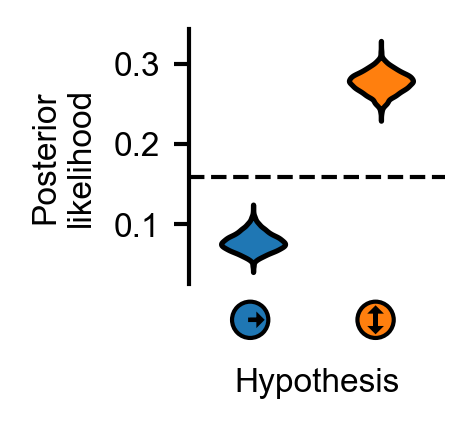

In [50]:
posterior = trace_bimodal["posterior"]

components = pm.VonMises.dist(
    mu=posterior["mu_pop"].values.reshape(-1, 2),
    kappa=posterior["kappa_pop"].values.reshape(-1, 2)
)

directions_mixture = pm.Mixture.dist(
    w=posterior["weights_pop"].values.reshape(-1, 2),
    comp_dists=components
)

p_forward = np.exp(pm.logp(directions_mixture, value=0).eval())

p_perp = (
    np.exp(pm.logp(directions_mixture, value=-np.pi / 2).eval() - np.log(2)) +
    np.exp(pm.logp(directions_mixture, value=np.pi / 2).eval() - np.log(2))
)
p_uniform = 1 / (2 * np.pi) 

# Stack probabilities for plotting
DATA = np.stack([p_forward, p_perp], axis=-1)

plt.figure(figsize=(1.1, 1.1), dpi=300)
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 8})

ax = sns.violinplot(data=DATA, inner=None, cut=0, width=0.5, linecolor='black', edgecolor='black', saturation=1.0)

# Additional adjustments
# ax.set_xticklabels([""])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("Hypothesis", labelpad=20)
ax.set_ylabel("Posterior\nlikelihood")

# Hide the default tick labels
ax.set_xticklabels([])
ax.set_xticks([])
ax.axhline(p_uniform, ls='--', c='k', label="uniform", lw=1)

for art in ax.collections:
    art.set_edgecolor('black')

fig = plt.gcf()
# Custom function to draw diagrams on the axis
def draw_diagram(ax, x, diagram_type):
    # Determine the position in figure space
    trans = ax.get_xaxis_transform() # This combines x in data units and y in axes fraction
    if diagram_type == "forward":
        # Draw circle with arrow pointing right
        ax.add_patch(Circle((x, 0), 0.055, clip_on=False, transform=fig.transFigure, edgecolor='black', facecolor='tab:blue'))
        ax.add_patch(FancyArrow(x, 0, 0.025, 0, clip_on=False, transform=fig.transFigure, head_width=0.02, head_length=0.01, edgecolor='black', facecolor='black'))
    elif diagram_type == "perpendicular":
        # Draw circle with two arrows pointing up and down
        ax.add_patch(Circle((x, 0), 0.055, clip_on=False, transform=fig.transFigure, edgecolor='black', facecolor='tab:orange'))
        ax.add_patch(FancyArrow(x, 0, 0, 0.025, clip_on=False, transform=fig.transFigure, head_width=0.02, head_length=0.01, edgecolor='black', facecolor='black'))
        ax.add_patch(FancyArrow(x, 0, 0, -0.025, clip_on=False, transform=fig.transFigure, head_width=0.02, head_length=0.01, edgecolor='black', facecolor='black'))

# Draw the diagrams for "forward" and "perpendicular"
draw_diagram(ax, 0.5-0.19, "forward")
draw_diagram(ax, 0.5+0.19, "perpendicular")

# Uncomment to save plot
# plt.savefig("./locust_directional_hypothesis.svg", bbox_inches="tight")
# plt.savefig("./locust_directional_hypothesis.pdf", bbox_inches="tight")
# plt.savefig("./locust_directional_hypothesis.png", bbox_inches="tight", dpi=300)

plt.show()


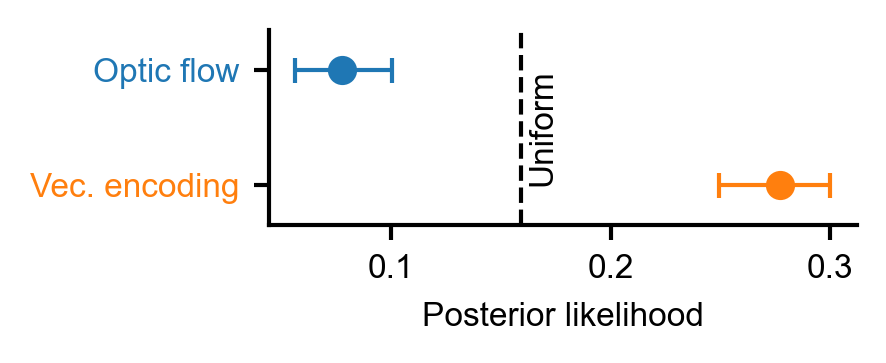

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

posterior = trace_bimodal["posterior"]

components = pm.VonMises.dist(
    mu=posterior["mu_pop"].values.reshape(-1, 2),
    kappa=posterior["kappa_pop"].values.reshape(-1, 2)
)

directions_mixture = pm.Mixture.dist(
    w=posterior["weights_pop"].values.reshape(-1, 2),
    comp_dists=components
)

# Likelihood at 0° (stimulus direction)  -> Optic flow
p_forward = np.exp(pm.logp(directions_mixture, value=0).eval())

# Likelihood at ±90° averaged            -> Vec. encoding
p_perp = (
    np.exp(pm.logp(directions_mixture, value=-np.pi / 2).eval() - np.log(2)) +
    np.exp(pm.logp(directions_mixture, value= np.pi / 2).eval() - np.log(2))
)

p_uniform = 1 / (2 * np.pi)

# -------------------------------------------------
# 95% HDI summary (same row order as before)
# row 0: Optic flow (p_forward)
# row 1: Vec. encoding (p_perp)
# -------------------------------------------------
vals  = [np.asarray(p_forward), np.asarray(p_perp)]
means = np.array([v.mean() for v in vals], dtype=float)
hdis  = np.vstack([az.hdi(v, hdi_prob=0.95) for v in vals]).astype(float)  # (2,2)

# Asymmetric errors: [[left], [right]] in the shape matplotlib expects
xerr = np.vstack([means - hdis[:, 0], hdis[:, 1] - means])  # (2,2)

# -------------------------------------------------
# Plot (match ELPD aesthetics)
# -------------------------------------------------
plt.rcParams.update({
    "ytick.major.width": 1,
    "xtick.major.width": 1,
    "axes.linewidth": 1,
    "lines.linewidth": 1,
    "font.family": "Arial",
    "font.size": 8,
})

labels = ["Optic flow", "Vec. encoding"]
colors = ["tab:blue", "tab:orange"]
y = np.arange(2)

fig, ax = plt.subplots(figsize=(3.0, 1.25), dpi=300)

for yi, m, xe_left, xe_right, col in zip(y, means, xerr[0], xerr[1], colors):
    ax.errorbar(
        m, yi,
        xerr=np.array([[xe_left], [xe_right]]),  # asymmetric
        fmt="o",
        color=col, ecolor=col,
        elinewidth=1, capsize=3, capthick=1,
        markersize=6,
        markeredgecolor=col,
        markeredgewidth=1,
        zorder=3
    )

ax.set_yticks(y)
ax.set_yticklabels(labels)

# Color tick labels to match
for lab, col in zip(ax.get_yticklabels(), colors):
    lab.set_color(col)

# Put Optic flow on TOP, Vec. encoding below (matches your original look)
ax.invert_yaxis()

ax.margins(y=0.35)
ax.set_xlabel("Posterior likelihood")
ax.set_ylabel("")
ax.set_title("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for sp in ax.spines.values():
    sp.set_linewidth(1)

ax.tick_params(axis="both", which="both",
               bottom=True, top=False,
               left=True, right=False,
               labelbottom=True, labelleft=True,
               width=1)

# Uniform reference line + label
ax.axvline(p_uniform, ls="--", c="k", lw=1, zorder=1)

# x in data coords, y in axes fraction (so inversion doesn't move it)
ax.text(
    p_uniform + 0.01, 0.8, "Uniform",
    rotation=90,
    va="top", ha="center",
    fontsize=8,
    color="k",
    transform=ax.get_xaxis_transform(),
    clip_on=False
)

plt.tight_layout()

plt.savefig("../figures/locust_directional_hypothesis_horizontal.png", dpi=300)
plt.savefig("../figures/locust_directional_hypothesis_horizontal.pdf")
plt.show()


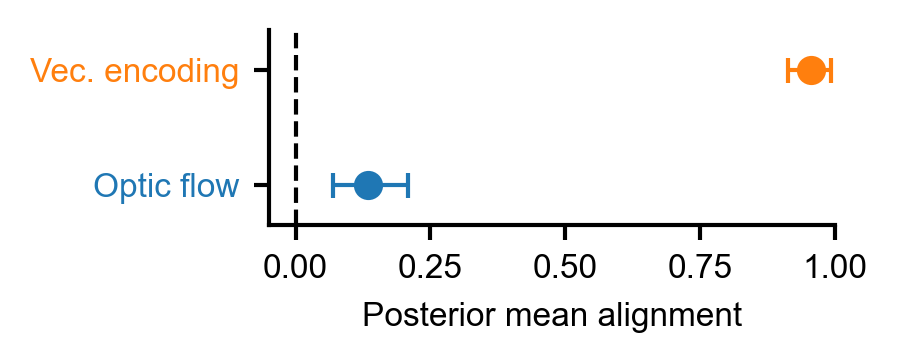

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# ----------------------------
# Compute posterior alignment (mean only; no kappa)
# ----------------------------
posterior = trace_bimodal["posterior"]

mu = posterior["mu_pop"].values.reshape(-1, 2)
w  = posterior["weights_pop"].values.reshape(-1, 2)

# Forward hypothesis: directional cosine similarity (range [-1, 1])
phi_forward = 0.0
align_forward = np.sum(w * np.cos(mu - phi_forward), axis=1)

# Perpendicular hypothesis: axial alignment (treat +pi/2 and -pi/2 as equivalent; range [-1, 1])
phi_perp = np.pi / 2
align_perp_axial = np.sum(w * np.cos(2 * (mu - phi_perp)), axis=1)

# ----------------------------
# 95% HDI summary
# ----------------------------
vals  = [np.asarray(align_forward), np.asarray(align_perp_axial)]
means = np.array([v.mean() for v in vals], dtype=float)
hdis  = np.vstack([az.hdi(v, hdi_prob=0.95) for v in vals]).astype(float)
xerr  = np.vstack([means - hdis[:, 0], hdis[:, 1] - means])  # asymmetric errors

# ----------------------------
# Plot styling (match your ELPD panel)
# ----------------------------
plt.rcParams.update({
    "ytick.major.width": 1,
    "xtick.major.width": 1,
    "axes.linewidth": 1,
    "lines.linewidth": 1,
    "font.family": "Arial",
    "font.size": 8,
})

labels = ["Optic flow", "Vec. encoding"]
colors = ["tab:blue", "tab:orange"]
y = np.arange(2)

fig, ax = plt.subplots(figsize=(3.0, 1.25), dpi=300)

for yi, m, xe, col in zip(y, means, xerr.T, colors):
    ax.errorbar(
        m, yi,
        xerr=np.array([[xe[0]], [xe[1]]]),  # asymmetric
        fmt="o",
        color=col, ecolor=col,
        elinewidth=1, capsize=3, capthick=1,
        markersize=6,
        markeredgecolor=col,
        markeredgewidth=1,
        zorder=3
    )

ax.set_yticks(y)
ax.set_yticklabels(labels)
for lab, col in zip(ax.get_yticklabels(), colors):
    lab.set_color(col)

ax.margins(y=0.35)

ax.set_xlabel("Posterior mean alignment")
ax.set_ylabel("")
ax.set_title("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for sp in ax.spines.values():
    sp.set_linewidth(1)

ax.tick_params(axis="both", which="both",
               bottom=True, top=False,
               left=True, right=False,
               labelbottom=True, labelleft=True,
               width=1)

# Baseline: zero expected alignment under uniformity
ax.axvline(0.0, ls="--", c="k", lw=1, zorder=1)

# Keep your original scale
ax.set_xlim(-0.05, 1.0)

plt.tight_layout()

plt.savefig("../figures/locust_directional_alignment_horizontal.png", dpi=300)
plt.savefig("../figures/locust_directional_alignment_horizontal.pdf")

plt.show()
